# Pandas case study

## Air quality data of European monitoring stations

Adapted from the PyCon Pandas Tutorial by Joris Van den Bossche and Stijn Van Hoey © under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)

AirBase is the European air quality database maintained by the European Environment Agency (EEA). It contains air quality monitoring data and information submitted by participating countries throughout Europe. The air quality database consists of a multi-annual time series of air quality measurement data and statistics for a number of air pollutants.

Some of the data files that are available from AirBase were included in the data folder: the hourly **concentrations of nitrogen dioxide (NO2)** for 4 different measurement stations:

- FR04037 (PARIS 13eme): urban background site at Square de Choisy
- FR04012 (Paris, Place Victor Basch): urban traffic site at Rue d'Alesia
- BETR802: urban traffic site in Antwerp, Belgium
- BETN029: rural background site in Houtem, Belgium

See http://www.eea.europa.eu/themes/air/interactive/no2

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 8

# Processing a single file

We will start with processing one of the downloaded files (`BETR8010000800100hour.1-1-1990.31-12-2012`). Looking at the data, you will see it does not look like a nice csv file:

In [ ]:
with open("data/BETR8010000800100hour.1-1-1990.31-12-2012") as f:
    print(f.readline())

So we will need to do some manual processing.

Just reading the tab-delimited data:

In [ ]:
data = pd.read_csv("data/BETR8010000800100hour.1-1-1990.31-12-2012", sep='\t')#, header=None)

In [ ]:
data.head()

The above data is clearly not ready to be used! Each row contains the 24 measurements for each hour of the day, and also contains a flag (0/1) indicating the quality of the data. Furthermore, there is no header row with column names.

<div class="alert alert-success">

<b>EXERCISE</b>: <br><br> Clean up this dataframe by using more options of `read_csv` (see its [docstring](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html))

 <ul>
  <li>specify the correct delimiter</li>
  <li>specify that the values of -999 and -9999 should be regarded as NaN</li>
   <li>specify are own column names</li>
</ul>
</div>

In [ ]:
# Column names: list consisting of 'date' and then intertwined the hour of the day and 'flag'
hours = ["{:02d}".format(i) for i in range(24)]
flags = ["flag{:02d}".format(i) for i in range(24)]
column_names = ['date'] + [item for pair in zip(hours, flags) for item in pair]

In [ ]:
data.head()

For the sake of this tutorial, we will disregard the 'flag' columns (indicating the quality of the data). 

<div class="alert alert-success">

<b>EXERCISE</b>:
<br><br>
    
Drop all 'flag' columns ('flag01', 'flag02', ...) 

In [ ]:
flag_columns = [col for col in data.columns if 'flag' in col]
# we can now use this list to drop these columns

In [ ]:
data.head()

Now, we want to reshape it: our goal is to have the different hours as row indices, merged with the date into a datetime-index. Here we have a wide and long dataframe, and want to make this a long, narrow timeseries.

<div class="alert alert-success">

<b>EXERCISE</b>:

<br><br>

Reshape the dataframe to a timeseries. 
The end result should look like:<br><br>


<div class='center'>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>BETR801</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1990-01-02 09:00:00</th>
      <td>48.0</td>
    </tr>
    <tr>
      <th>1990-01-02 12:00:00</th>
      <td>48.0</td>
    </tr>
    <tr>
      <th>1990-01-02 13:00:00</th>
      <td>50.0</td>
    </tr>
    <tr>
      <th>1990-01-02 14:00:00</th>
      <td>55.0</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
    </tr>
    <tr>
      <th>2012-12-31 20:00:00</th>
      <td>16.5</td>
    </tr>
    <tr>
      <th>2012-12-31 21:00:00</th>
      <td>14.5</td>
    </tr>
    <tr>
      <th>2012-12-31 22:00:00</th>
      <td>16.5</td>
    </tr>
    <tr>
      <th>2012-12-31 23:00:00</th>
      <td>15.0</td>
    </tr>
  </tbody>
</table>
<p style="text-align:center">170794 rows × 1 columns</p>
</div>

 <ul>
  <li>Reshape the dataframe so that each row consists of one observation for one date + hour combination</li>
  <li>When you have the date and hour values as two columns, combine these columns into a datetime (tip: string columns can be summed to concatenate the strings) and remove the original columns</li>
  <li>Set the new datetime values as the index, and remove the original columns with date and hour values</li>

</ul>

</div>



Our final data is now a time series. In pandas, this means that the index is a `DatetimeIndex`:

In [ ]:
data_stacked.index

In [ ]:
data_stacked.plot()

# Processing a collection of files

We now have seen the code steps to process one of the files. We have however multiple files for the different stations with the same structure. Therefore, to not have to repeat the actual code, let's make a function from the steps we have seen above.

In [ ]:
def read_airbase_file(filename, station):
    """
    Read hourly AirBase data files.
    
    Parameters
    ----------
    filename : string
        Path to the data file.
    station : string
        Name of the station.
       
    Returns
    -------
    DataFrame
        Processed dataframe.
    """
    
    # construct the column names    
    hours = ["{:02d}".format(i) for i in range(24)]
    flags = ["flag{:02d}".format(i) for i in range(24)]
    colnames = ['date'] + [item for pair in zip(hours, flags) for item in pair]
    
    # read the actual data
    data = pd.read_csv(filename, sep='\t', header=None, na_values=[-999, -9999], names=colnames)
    
    # drop the 'flag' columns
    data = data.drop([col for col in data.columns if 'flag' in col], axis=1)

    # reshape
    data = data.set_index('date')
    data_stacked = data.stack()
    data_stacked = data_stacked.reset_index()
    
    # parse to datetime and remove redundant columns 
    data_stacked.index = pd.to_datetime(data_stacked['date'] + data_stacked['level_1'], format="%Y-%m-%d%H")
    data_stacked = data_stacked.drop(['date', 'level_1'], axis=1)
    data_stacked = data_stacked.rename(columns={0: station})
    
    return data_stacked

Test the function on the data file from above:

In [ ]:
filename = "data/BETR8010000800100hour.1-1-1990.31-12-2012"
station = filename.split("/")[-1][:7]

In [ ]:
station

In [ ]:
test = read_airbase_file(filename, station)
test.head()

We now want to use this function to read in all the different data files from AirBase, and combine them into one Dataframe. 

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Use the `glob.glob` function to list all 4 AirBase data files that are included in the 'data' directory, and call the result `data_files`.</li>
</ul>
</div>

In [ ]:
import glob

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Loop over the data files, read and process the file using our defined function, and append the dataframe to a list.</li>
  <li>Combine the the different DataFrames in the list into a single DataFrame where the different columns are the different stations. Call the result `combined_data`.</li>

</ul>
</div>

In [ ]:
combined_data.head()

Finally, we don't want to have to repeat this each time we use the data. Therefore, let's save the processed data to a csv file.

In [ ]:
combined_data.to_csv("airbase_data.csv")

# Working with time series data

We processed the individual data files above, and saved it to a csv file `airbase_data.csv`. Let's import the file here (if you didn't finish the above exercises, a version of the dataset will also be made available in `data/airbase_data.csv`):

In [22]:
import pandas as pd
import numpy as np
alldata = pd.read_csv('data/airbase_data.csv', index_col=0, parse_dates=True)

We only use the data from 1999 onwards:

In [3]:
data = alldata['1999':].copy()

Som first exploration with the *typical* functions:

In [4]:
data.head() # tail()

,BETR801,BETN029,FR04037,FR04012
1999-01-01 00:00:00,27.0,13.0,68.0,105.0
1999-01-01 01:00:00,33.0,15.0,70.0,116.0
1999-01-01 02:00:00,24.0,16.0,72.0,114.0
1999-01-01 03:00:00,26.0,18.0,72.0,91.0
1999-01-01 04:00:00,NaN,19.0,74.0,81.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122736 entries, 1999-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BETR801  106628 non-null  float64
 1   BETN029  111989 non-null  float64
 2   FR04037  120384 non-null  float64
 3   FR04012  119448 non-null  float64
dtypes: float64(4)
memory usage: 4.7 MB


In [6]:
data.describe(percentiles=[0.1, 0.5, 0.9])

,BETR801,BETN029,FR04037,FR04012
count,106628.000000,111989.00000,120384.000000,119448.000000
mean,46.728969,16.42093,40.040005,87.993261
std,21.708333,12.31968,23.024347,41.317684
min,1.000000,1.00000,0.000000,0.000000
10%,21.000000,4.00000,14.000000,37.000000
50%,45.000000,12.00000,37.000000,88.000000
90%,75.000000,34.00000,70.000000,139.000000
max,339.000000,105.00000,256.000000,358.000000


Quickly visualizing the data

<AxesSubplot:>

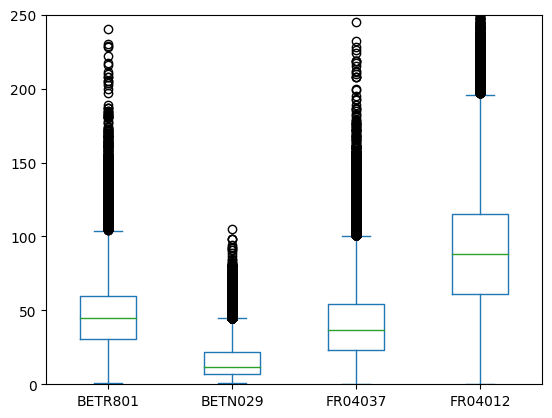

In [7]:
data.plot(kind='box', ylim=[0,250])

<AxesSubplot:ylabel='Frequency'>

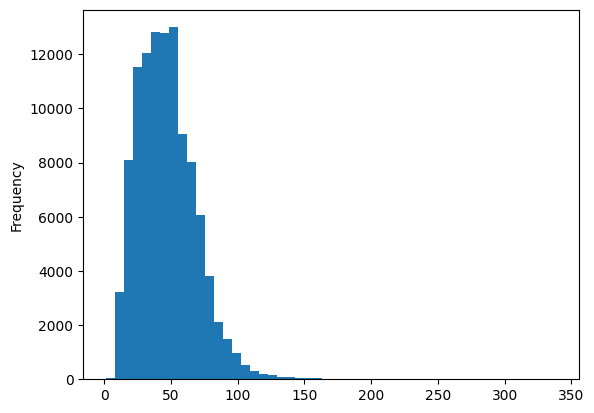

In [8]:
data['BETR801'].plot(kind='hist', bins=50)

<AxesSubplot:>

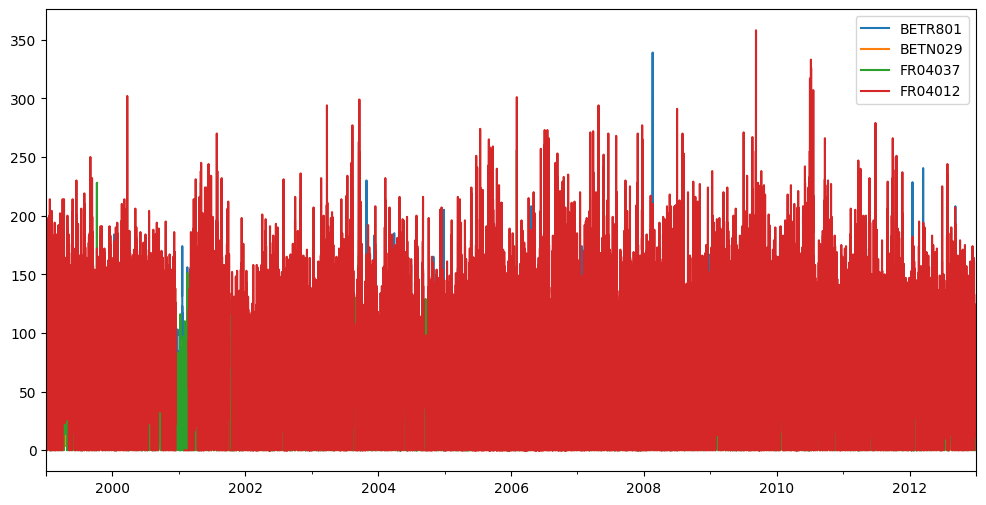

In [9]:
data.plot(figsize=(12,6))

This does not say too much ..

We can select part of the data (eg the latest 500 data points):

<AxesSubplot:>

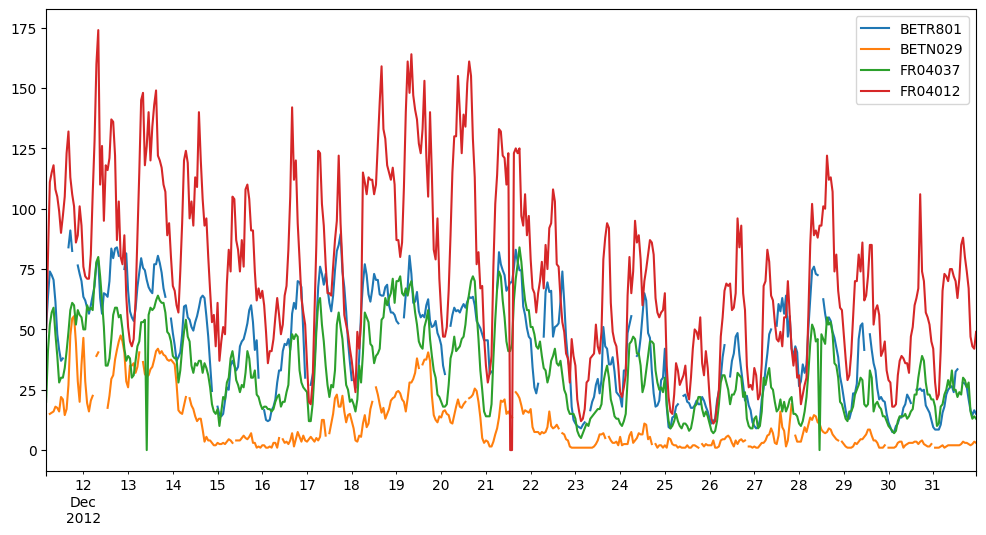

In [10]:
data[-500:].plot(figsize=(12,6))

## Exercises

<div class="alert alert-success">
    <b>EXERCISE</b>: plot the monthly mean and median concentration of the 'FR04037' station for the years 2009-2012
</div>

<AxesSubplot:>

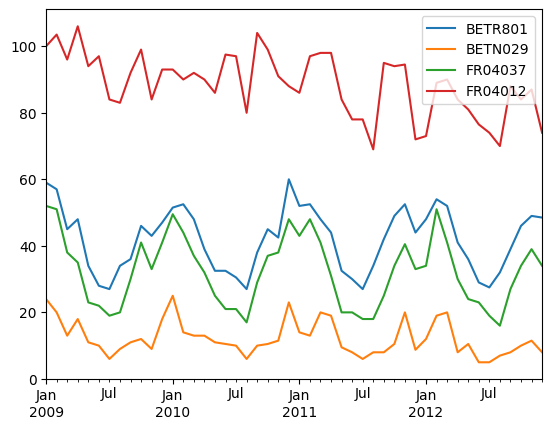

In [15]:
data.loc['2009':, :].resample('M').median().plot()

In [16]:
data.loc['2009':, 'FR04037'].resample('M').mean()

2009-01-31    54.758065
2009-02-28    51.630952
2009-03-31    43.799731
2009-04-30    41.165278
2009-05-31    26.693627
2009-06-30    26.438889
2009-07-31    23.245968
2009-08-31    26.818548
2009-09-30    35.913194
2009-10-31    42.385753
2009-11-30    36.248611
2009-12-31    41.393750
2010-01-31    49.922043
2010-02-28    46.162202
2010-03-31    42.663978
2010-04-30    39.683333
2010-05-31    27.916667
2010-06-30    26.276786
2010-07-31    27.201613
2010-08-31    21.555108
2010-09-30    36.594444
2010-10-31    40.591398
2010-11-30    38.700000
2010-12-31    47.754032
2011-01-31    43.552419
2011-02-28    47.665179
2011-03-31    45.251437
2011-04-30    38.312500
2011-05-31    25.909946
2011-06-30    22.793056
2011-07-31    21.741935
2011-08-31    22.299731
2011-09-30    33.529167
2011-10-31    39.329301
2011-11-30    42.226389
2011-12-31    35.413978
2012-01-31    36.966398
2012-02-29    50.550287
2012-03-31    44.841398
2012-04-30    34.093056
2012-05-31    28.844086
2012-06-30    25

<div class="alert alert-warning">
Question 196 [using plotly]: What is the monthly mean concentration of the `FR04037` station for the month of March, 2009?
<br>
<p><b>Tip</b>: plotly.express.line or scatter can be helpful.</p>
</div>

<div class="alert alert-warning">
Question 197 [using plotly]: In 2011, how many subsequent months have a monthly mean concentration below 30 for the `FR04037` station?<br>
<p><b>Tip</b>: plotly.express.line or scatter can be helpful.</p>
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>: plot the monthly mininum and maximum daily concentration of the 'FR04037' station
</div>

In [17]:
daily = data['FR04037'].resample('D').mean()

<AxesSubplot:>

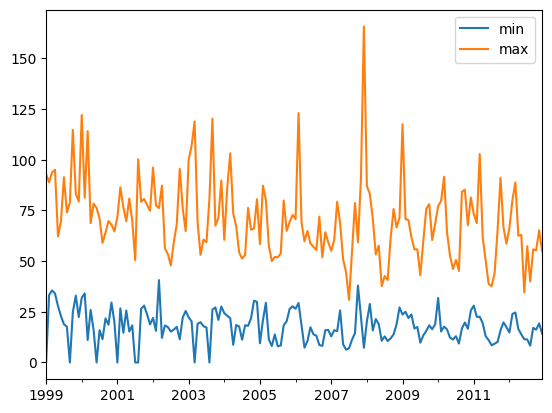

In [18]:
daily.resample('M').agg(['min', 'max']).plot()

In [23]:
np.round(daily['2007-03-19'],6)

28.791667

<div class="alert alert-warning">
Question 198 [using plotly]: For the station `FR04037`, during one year the minimum value of the monthly max concentration was smaller than the maximum value of the monthly min concentration from another month. What is this peak maximum value of the monthly min concentration? <i>(3 decimal precision required in the answer)</i><br>
<p><b>Tip</b>: plotly.express.line or scatter can be helpful.</p>
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>: make a bar plot of the mean of the stations in year of 2012
</div>

<div class="alert alert-warning">
Question 199 [using plotly]: What is the second to greatest yearly mean concentration of the `BETR801` station? <i>(3 decimal precision required in the answer)</i><br>
<p><b>Tip</b>: plotly.express.pie can be helpful.</p>
</div>

In [26]:
yearly = data['BETR801'].resample('Y').mean()

In [27]:
yearly

1999-12-31    49.764002
2000-12-31    48.154520
2001-12-31    48.045962
2002-12-31    47.876558
2003-12-31    50.475548
2004-12-31    47.400254
2005-12-31    47.214689
2006-12-31    46.460865
2007-12-31    44.797874
2008-12-31    44.841840
2009-12-31    44.840894
2010-12-31    44.268677
2011-12-31    45.734780
2012-12-31    44.719543
Freq: A-DEC, Name: BETR801, dtype: float64

<div class="alert alert-success">
    <b>EXERCISE</b>: Plot the evolution of the yearly averages and the overall mean of all stations (indicate the overall mean with a thicker black line).
</div>

<div class="alert alert-warning">
Question 200: What is the average of the overall mean concentration sampled yearly for the year 2010?
</div>

In [115]:
data.loc['2010', :].mean(axis=1).mean()

48.22866723744292

In [52]:
np.round(data.loc['2010'].stack().mean(),6)

48.010052

In [86]:
np.round(data.resample('Y').mean().loc['2010'].mean().mean(),6)

47.542839

In [105]:
np.round(data.groupby(data.index.year).mean().loc[2010].mean(),6)

47.542839

In [75]:
np.round(data.loc['2010', :].mean(axis=1).mean(),6)

48.228667

In [117]:
data.loc['2010', :]

,BETR801,BETN029,FR04037,FR04012
2010-01-01 00:00:00,20.0,10.0,30.0,57.0
2010-01-01 01:00:00,20.0,10.0,27.0,54.0
2010-01-01 02:00:00,16.0,9.0,20.0,42.0
2010-01-01 03:00:00,15.0,9.0,18.0,42.0
2010-01-01 04:00:00,13.0,8.0,20.0,41.0
...,...,...,...,...
2010-12-31 19:00:00,72.0,NaN,34.0,90.0
2010-12-31 20:00:00,69.0,40.0,39.0,75.0
2010-12-31 21:00:00,65.0,39.0,28.0,67.0
2010-12-31 22:00:00,60.0,38.0,26.0,60.0


In [118]:
data.loc['2010'].stack()

2010-01-01 00:00:00  BETR801    20.0
                     BETN029    10.0
                     FR04037    30.0
                     FR04012    57.0
2010-01-01 01:00:00  BETR801    20.0
                                ... 
2010-12-31 22:00:00  FR04012    60.0
2010-12-31 23:00:00  BETR801    56.0
                     BETN029    39.0
                     FR04037    25.0
                     FR04012    61.0
Length: 33228, dtype: float64